In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

import numpy as np

from sklearn.utils import shuffle
from scipy.spatial import distance_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import MDS
from sklearn.utils.class_weight import compute_class_weight

import matplotlib
import matplotlib.pyplot as plt

import networkx as nx
import torch_geometric

import pandas as pd
from timeit import default_timer as timer
from torchinfo import summary
from tqdm.auto import tqdm

from torch.utils.tensorboard import SummaryWriter

In [2]:
class myGCNlayerV1(nn.Module):
    def __init__(self, hidden_dim, num_nodes, batch_dim):
        super().__init__()
        self.W1=nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.W2=nn.Linear(in_features=hidden_dim, out_features=hidden_dim)

        self.W3=nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.W4=nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.BNnode=nn.BatchNorm1d(num_features=hidden_dim, track_running_stats=False)
        self.BNedge=nn.BatchNorm2d(num_features=hidden_dim, track_running_stats=False)
        self.ReLU=nn.ReLU()

        self.dropout=nn.Dropout(p=0.2)

    def forward(self, x, e):
        e_in=e
        x_in=x

        # Edge Convolution e=[B x V x V x H], x=[B x V x H]
        W1_e=self.W1(e)
        W2_tmp=self.W2(x)
        W2_xi=W2_tmp.unsqueeze(dim=1)  # B x V x H -> B x 1 x V x H
        W2_xj=W2_tmp.unsqueeze(dim=2)  # B x V x H -> B x V x 1 x H
        e_feat=W1_e+W2_xi+W2_xj

        # Node Convolution x=[B x V x H], e_feat=[B x V x V x H]
        W3_xi=self.W3(x)
        W4_xj=self.W4(x)
        W4_xj=W4_xj.unsqueeze(dim=1)  # B x V x H -> B x 1 x V x H
        eta_W4_xj=W4_xj*e_feat.sigmoid()  # (B x 1 x V x H)⋅(B x V x V x H) = B x V x V x H
        eta_W4_xj=eta_W4_xj.sum(dim=2)  # B x V x V x H -> B x V x H
        epsilon=1e-20  # a small value
        eta_W4_xj/=(e_feat.sigmoid().sum(dim=2)+epsilon)  # mean aggregation
        x_feat=W3_xi+eta_W4_xj

        # Batch Normalizatin
        e_bn=self.BNedge(e_feat.transpose(1, 3))  # B x V x V x H -> B x H x V x V
        e_bn=e_bn.transpose(1, 3)  # reshape to original shape

        x_bn=self.BNnode(x_feat.transpose(1, 2))  # B x V x H -> B x H x V
        x_bn=x_bn.transpose(1, 2)  # reshape to original shape

        # ReLU Activation
        e_relu=self.ReLU(e_bn)
        x_relu=self.ReLU(x_bn)

        # Residual Connection
        e_layer=e_in+e_relu
        x_layer=x_in+x_relu
        return x_layer, e_layer

class myGCNlayerV2(nn.Module):
    def __init__(self, hidden_dim, num_nodes, batch_dim):
        super().__init__()
        self.W1=nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.W2=nn.Linear(in_features=hidden_dim, out_features=hidden_dim*num_nodes)

        self.W3=nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.W4=nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.BNnode=nn.BatchNorm1d(num_features=hidden_dim, track_running_stats=False)
        self.BNedge=nn.BatchNorm2d(num_features=hidden_dim, track_running_stats=False)
        self.ReLU=nn.ReLU()

        self.num_nodes=num_nodes
        self.hidden_dim=hidden_dim
        self.batch_dim=batch_dim

    def forward(self, x, e):
        e_in=e
        x_in=x

        # Edge Convolution e=[B x V x V x H], x=[B x V x H]
        W1_e=self.W1(e)
        W2_tmp=self.W2(x)
        if e.shape[0]==1:
            W2_x=W2_tmp.reshape(1, self.num_nodes, self.num_nodes, self.hidden_dim)  # 1 x V x (HxV) -> 1 x V x V x H
        else:
            W2_x=W2_tmp.reshape(self.batch_dim, self.num_nodes, self.num_nodes, self.hidden_dim)  # B x V x (HxV) -> B x V x V x H
        e_feat=W1_e+W2_x

        # Node Convolution x=[B x V x H], e_feat=[B x V x V x H]
        W3_xi=self.W3(x)
        W4_xj=self.W4(x)
        W4_xj=W4_xj.unsqueeze(dim=1)  # B x V x H -> B x 1 x V x H
        eta_W4_xj=W4_xj*e_feat.sigmoid()  # (B x 1 x V x H)⋅(B x V x V x H) = B x V x V x H
        eta_W4_xj=eta_W4_xj.sum(dim=2)  # B x V x V x H -> B x V x H
        epsilon=1e-20  # a small value
        eta_W4_xj/=(e_feat.sigmoid().sum(dim=2)+epsilon)  # mean aggregation
        x_feat=W3_xi+eta_W4_xj

        # Batch Normalizatin
        e_bn=self.BNedge(e_feat.transpose(1, 3))  # B x V x V x H -> B x H x V x V
        e_bn=e_bn.transpose(1, 3)  # reshape to original shape

        x_bn=self.BNnode(x_feat.transpose(1, 2))  # B x V x H -> B x H x V
        x_bn=x_bn.transpose(1, 2)  # reshape to original shape

        # ReLU Activation
        e_relu=self.ReLU(e_bn)
        x_relu=self.ReLU(x_bn)

        # Residual Connection
        e_layer=e_in+e_relu
        x_layer=x_in+x_relu
        return x_layer, e_layer

class myGCNlayerV3(nn.Module):
    def __init__(self, hidden_dim, num_nodes, batch_dim):
        super().__init__()
        self.W1=nn.Linear(in_features=hidden_dim*num_nodes, out_features=hidden_dim)
        self.W2=nn.Linear(in_features=hidden_dim, out_features=hidden_dim)

        self.W3=nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.W4=nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.BNnode=nn.BatchNorm1d(num_features=hidden_dim, track_running_stats=False)
        self.BNedge=nn.BatchNorm1d(num_features=hidden_dim, track_running_stats=False)
        self.ReLU=nn.ReLU()

        self.num_nodes=num_nodes
        self.batch_dim=batch_dim

        self.dropout=nn.Dropout(p=0.4)

    def forward(self, x, e):
        e_in=e
        x_in=x

        # Edge Convolution e=[B x V x V x H], x=[B x V x H]
        if e.shape[0]==1:
            W1_e=self.W1(e.reshape(1, self.num_nodes, -1))  # 1 x V x V x H -> 1 x V x (V*H) -> 1 x V x H
        else:
            W1_e=self.W1(e.reshape(self.batch_dim, self.num_nodes, -1))  # B x V x V x H -> B x V x (V*H) -> B x V x H
        W1_e=self.dropout(W1_e)

        W2_x=self.W2(x)  # B x V x H
        W2_x=self.dropout(W2_x)

        e_feat=W1_e+W2_x

        # Node Convolution x=[B x V x H], e_feat=[B x V x H]
        W3_xi=self.W3(x)
        W3_xi=self.dropout(W3_xi)

        W4_xj=self.W4(x)
        W4_xj=self.dropout(W4_xj)
        eta_W4_xj=W4_xj*e_feat.sigmoid()  # B x V x H

        # mean aggregation
        epsilon=1e-20  # a small value
        #eta_W4_xj/=(e_feat.sigmoid().sum(dim=1)+epsilon)  # got a shape error I
        eta_W4_xj/=(e_feat.sigmoid().sum(dim=1, keepdim=True)+epsilon)  # got a shape error
        x_feat=W3_xi+eta_W4_xj

        # Apply dropout before ReLU Activation
        #x_feat=self.dropout(x_feat)
        #e_feat=self.dropout(e_feat)

        # Batch Normalizatin
        e_bn=self.BNedge(e_feat.transpose(1, 2))  # B x V x H -> B x H x V
        e_bn=e_bn.transpose(1, 2)  # reshape to original shape

        x_bn=self.BNnode(x_feat.transpose(1, 2))  # B x V x H -> B x H x V
        x_bn=x_bn.transpose(1, 2)  # reshape to original shape

        # ReLU Activation
        e_relu=self.ReLU(e_bn)
        x_relu=self.ReLU(x_bn)

        # Residual Connection
        e_relu=e_relu.unsqueeze(dim=1)  # got a shape error II
        e_layer=e_in+e_relu  # B x V x V x H  + B x V x 1 x H (broadcasting), B x V x V x H + B x 1 x V x H (pairing)
        x_layer=x_in+x_relu
        return x_layer, e_layer

sum at `dim=1` and `dim=2` not same

In [3]:
torch.manual_seed(69)
A=torch.rand(1, 2, 2, 3)
B=torch.rand(1, 2, 3)
print("A:", A)
print("B:", B)
print("Case1:", A+B)  # pairing sum
print("Case2:", A+B.unsqueeze(dim=1))  # same as case1 (pairing sum)
print("Case3:", A+B.unsqueeze(dim=2))  # not same as case2 (broadcasting sum)

A: tensor([[[[0.8398, 0.8042, 0.1213],
          [0.5309, 0.6646, 0.4077]],

         [[0.0888, 0.2429, 0.7053],
          [0.6216, 0.9188, 0.0185]]]])
B: tensor([[[0.8741, 0.0560, 0.9659],
         [0.0073, 0.3628, 0.4197]]])
Case1: tensor([[[[1.7139, 0.8601, 1.0873],
          [0.5382, 1.0275, 0.8274]],

         [[0.9629, 0.2989, 1.6713],
          [0.6289, 1.2816, 0.4382]]]])
Case2: tensor([[[[1.7139, 0.8601, 1.0873],
          [0.5382, 1.0275, 0.8274]],

         [[0.9629, 0.2989, 1.6713],
          [0.6289, 1.2816, 0.4382]]]])
Case3: tensor([[[[1.7139, 0.8601, 1.0873],
          [1.4051, 0.7206, 1.3737]],

         [[0.0961, 0.6057, 1.1250],
          [0.6289, 1.2816, 0.4382]]]])


In [4]:
def create_myGCNlayer(version, hidden_dim, num_nodes, batch_dim):
    if version == 1:
        return myGCNlayerV1(hidden_dim, num_nodes, batch_dim)
    elif version == 2:
        return myGCNlayerV2(hidden_dim, num_nodes, batch_dim)
    elif version == 3:
        return myGCNlayerV3(hidden_dim, num_nodes, batch_dim)
    else:
        raise ValueError(f"Unsupported version: {version}")

class myGCNmodel(nn.Module):
    def __init__(self, hidden_dim, num_nodes, batch_dim, version):
        super().__init__()
        self.node_emb=nn.Linear(in_features=2, out_features=hidden_dim, bias=False)
        self.edge_emb_val=nn.Linear(in_features=1, out_features=hidden_dim//2, bias=False)
        self.edge_emb_knn=nn.Embedding(num_embeddings=3, embedding_dim=hidden_dim//2)
        # 5 GCN layers
        self.gcn_layers=nn.Sequential(
            create_myGCNlayer(version, hidden_dim, num_nodes, batch_dim),
            create_myGCNlayer(version, hidden_dim, num_nodes, batch_dim),
            create_myGCNlayer(version, hidden_dim, num_nodes, batch_dim),
            create_myGCNlayer(version, hidden_dim, num_nodes, batch_dim),
            create_myGCNlayer(version, hidden_dim, num_nodes, batch_dim),
        )
        # 2 MLP layers
        self.mlp_layers=nn.Sequential(
            nn.Linear(in_features=hidden_dim, out_features=hidden_dim),  # B x V x V x H
            nn.ReLU(),
            nn.Linear(in_features=hidden_dim, out_features=hidden_dim),  # B x V x V x H
            nn.ReLU(),
            nn.Linear(in_features=hidden_dim, out_features=2)  # B x V x V x H -> B x V x V x 2 (MLP last)
        )

    def forward(self, adj, dist, coord):
        # Node embedding
        x=self.node_emb(coord)  # B x V x H

        # Edge embedding
        dist=dist.unsqueeze(dim=3)  # B x V x V -> B x V x V x 1
        e_val=self.edge_emb_val(dist)  # B x V x V x 1 -> B x V x V x H/2
        e_knn=self.edge_emb_knn(adj)  # B x V x V -> B x V x V x H/2
        e=torch.cat((e_val, e_knn), dim=3)   # [B x V x V x H/2] [B x V x V x H/2] = B x V x V x H

        # GCN layers
        for gcn in self.gcn_layers:
            x, e=gcn(x, e)  # B x V x H, B x V x V x H

        # MLP
        e_pred=e  # B x V x V x H -> B x V x V x 2 (in the last MLP layer)
        for mlp in self.mlp_layers:
            e_pred=mlp(e_pred)

        return e_pred

In [5]:
from torch_geometric.nn import SAGEConv, TransformerConv
from torch_geometric.utils import sort_edge_index

class myGCNGraphSAGE(nn.Module):
    def __init__(self, hidden_dim, num_nodes, batch_dim, version):
        super().__init__()
        self.batch_dim=batch_dim
        self.graphsage=SAGEConv(in_channels=2, out_channels=hidden_dim, aggr='lstm')
        self.edge_emb_val=nn.Linear(in_features=1, out_features=hidden_dim//2, bias=False)
        self.edge_emb_knn=nn.Embedding(num_embeddings=3, embedding_dim=hidden_dim//2)
        # 5 GCN layers
        self.gcn_layers=nn.ModuleList([create_myGCNlayer(version, hidden_dim, num_nodes, batch_dim) for _ in range(5)])
        # 2 MLP layers
        self.mlp_layers=nn.Sequential(
            nn.Linear(in_features=hidden_dim, out_features=hidden_dim),  # B x V x V x H
            nn.ReLU(),
            nn.Linear(in_features=hidden_dim, out_features=hidden_dim),  # B x V x V x H
            nn.ReLU(),
            nn.Linear(in_features=hidden_dim, out_features=2)  # B x V x V x H -> B x V x V x 2 (MLP last)
        )

    def fixed_index(self, tensor, num_nodes):
        """
        Adjusts the indices of a given tensor based on the number of nodes.

        Args:
            tensor (list): The input tensor.

        Returns:
            list: The tensor with adjusted indices.
        """
        for i in range(len(tensor[0])):
            step = tensor[0][i] // num_nodes
            tensor[1][i] += step * num_nodes
        return tensor

    def forward(self, adj, dist, coord):
        """
        Parameters:
            adj (torch.Tensor): Adjacency matrix of shape (B x V x V), where B is the batch size and V is the number of nodes.
            dist (torch.Tensor): Distance matrix of shape (B x V x V), where B is the batch size and V is the number of nodes.
            coord (torch.Tensor): Coordinate matrix of shape (B x V x 2)
        """
        # Node embedding
        edge_index=adj.reshape(-1, adj.shape[2]).eq(1).nonzero().t().contiguous()
        edge_index=self.fixed_index(tensor=edge_index, num_nodes=adj.shape[2])   # need to adjust the edge index when there are multiple graphs or batch size > 1

        sorted_edge_index=sort_edge_index(edge_index, num_nodes=adj.shape[2], sort_by_row=False)
        x=self.graphsage(coord.view(-1, 2), sorted_edge_index)

        if adj.shape[0]==1:  # val and test set have batch size of 1
            x=x.reshape(1, adj.shape[2], -1)
        else:  # train set has batch size of B
            x=x.reshape(self.batch_dim, adj.shape[2], -1)

        # Edge embedding
        dist=dist.unsqueeze(dim=3)  # B x V x V -> B x V x V x 1
        e_val=self.edge_emb_val(dist)  # B x V x V x 1 -> B x V x V x H/2
        e_knn=self.edge_emb_knn(adj)  # B x V x V -> B x V x V x H/2
        e=torch.cat((e_val, e_knn), dim=3)   # [B x V x V x H/2] [B x V x V x H/2] = B x V x V x H

        # GCN layers
        for gcn in self.gcn_layers:
            x, e=gcn(x, e)  # B x V x H, B x V x V x H

        # MLP
        e_pred=e  # B x V x V x H -> B x V x V x 2 (in the last MLP layer)
        for mlp in self.mlp_layers:
            e_pred=mlp(e_pred)

        return e_pred

class myGCNTransformer(nn.Module):
    def __init__(self, hidden_dim, num_nodes, batch_dim, version):
        super().__init__()
        self.batch_dim=batch_dim
        self.transformer=TransformerConv(in_channels=2, out_channels=hidden_dim)
        self.edge_emb_val=nn.Linear(in_features=1, out_features=hidden_dim//2, bias=False)
        self.edge_emb_knn=nn.Embedding(num_embeddings=3, embedding_dim=hidden_dim//2)
        # 5 GCN layers
        self.gcn_layers=nn.ModuleList([create_myGCNlayer(version, hidden_dim, num_nodes, batch_dim) for _ in range(5)])
        # 2 MLP layers
        self.mlp_layers=nn.Sequential(
            nn.Linear(in_features=hidden_dim, out_features=hidden_dim),  # B x V x V x H
            nn.ReLU(),
            nn.Linear(in_features=hidden_dim, out_features=hidden_dim),  # B x V x V x H
            nn.ReLU(),
            nn.Linear(in_features=hidden_dim, out_features=2)  # B x V x V x H -> B x V x V x 2 (MLP last)
        )

    def fixed_index(self, tensor, num_nodes):
        """
        Adjusts the indices of a given tensor based on the number of nodes.

        Args:
            tensor (list): The input tensor.

        Returns:
            list: The tensor with adjusted indices.
        """
        for i in range(len(tensor[0])):
            step = tensor[0][i] // num_nodes
            tensor[1][i] += step * num_nodes
        return tensor

    def forward(self, adj, dist, coord):
        """
        Parameters:
            adj (torch.Tensor): Adjacency matrix of shape (B x V x V), where B is the batch size and V is the number of nodes.
            dist (torch.Tensor): Distance matrix of shape (B x V x V), where B is the batch size and V is the number of nodes.
            coord (torch.Tensor): Coordinate matrix of shape (B x V x 2)
        """
        # Node embedding
        edge_index=adj.reshape(-1, adj.shape[2]).eq(1).nonzero().t().contiguous()
        edge_index=self.fixed_index(tensor=edge_index, num_nodes=adj.shape[2])   # need to adjust the edge index when there are multiple graphs or batch size > 1

        #print(coord.shape, coord.view(-1, 2).shape)
        #print(adj.shape, edge_index.shape)
        x=self.transformer(coord.view(-1, 2), edge_index)

        if adj.shape[0]==1:  # val and test set have batch size of 1
            x=x.reshape(1, adj.shape[2], -1)
        else:  # train set has batch size of B
            x=x.reshape(self.batch_dim, adj.shape[2], -1)

        # Edge embedding
        dist=dist.unsqueeze(dim=3)  # B x V x V -> B x V x V x 1
        e_val=self.edge_emb_val(dist)  # B x V x V x 1 -> B x V x V x H/2
        e_knn=self.edge_emb_knn(adj)  # B x V x V -> B x V x V x H/2
        e=torch.cat((e_val, e_knn), dim=3)   # [B x V x V x H/2] [B x V x V x H/2] = B x V x V x H

        # GCN layers
        for gcn in self.gcn_layers:
            x, e=gcn(x, e)  # B x V x H, B x V x V x H

        # MLP
        e_pred=e  # B x V x V x H -> B x V x V x 2 (in the last MLP layer)
        for mlp in self.mlp_layers:
            e_pred=mlp(e_pred)

        return e_pred

PyG `sort_edge_index` for LSTM

In [6]:
test_tensor = torch.tensor([[[2, 1, 1],
                             [1, 2, 1],
                             [1, 1, 2]], 
                             [[2, 0, 1],
                             [1, 2, 1],
                             [1, 1, 2]]])

#test_tensor = torch.tensor([[2, 1, 1], [1, 2, 1], [1, 1, 2]])

test_tensor = test_tensor.view(-1, 3)
test_tensor = test_tensor.eq(1).nonzero().t().contiguous()
print("test tensor:\n", test_tensor)

num_nodes = 3
for i in range(len(test_tensor[0])):
    step = test_tensor[0][i]//num_nodes
    #print(test_tensor[0][i], "-", int(test_tensor[0][i]%num_nodes), "step =", int(step))
    test_tensor[1][i] += step*num_nodes

print("test tensor (re-index):\n", test_tensor)
print("sort test tensor:\n", sort_edge_index(test_tensor, num_nodes=3, sort_by_row=False))

test tensor:
 tensor([[0, 0, 1, 1, 2, 2, 3, 4, 4, 5, 5],
        [1, 2, 0, 2, 0, 1, 2, 0, 2, 0, 1]])
test tensor (re-index):
 tensor([[0, 0, 1, 1, 2, 2, 3, 4, 4, 5, 5],
        [1, 2, 0, 2, 0, 1, 5, 3, 5, 3, 4]])
sort test tensor:
 tensor([[1, 2, 0, 2, 0, 1, 4, 5, 5, 3, 4],
        [0, 0, 1, 1, 2, 2, 3, 3, 4, 5, 5]])


In [7]:
class TSPDict(dict):
    def __init(self, **keys):
        self.update(keys)
        self.__dict__=self

class TSPReader(object):
    def __init__(self, num_nodes, num_neighbors, batch_size, file_path, set_seed=None):
        if set_seed != None:
            np.random.seed(set_seed)
        self.file_path=file_path
        self.filedata=shuffle(open(self.file_path, "r").readlines())
        self.num_nodes=num_nodes
        self.num_neighbors=num_neighbors
        self.batch_size=batch_size
        self.max_iter=len(self.filedata)//self.batch_size

    def __iter__(self):
        for batch in range(self.max_iter):
            start=batch*self.batch_size
            end=(batch+1)*self.batch_size
            yield self.create_batch(self.filedata[start:end])

    def create_batch(self, lines):
        batch_coord=[]
        batch_adj=[]
        batch_dist=[]
        batch_target=[]
        for index, line in enumerate(lines):
            line=line.split(' ')
            #print(f'{index} {line}')

            # node coordinates
            node_coord=[]
            for i in range(0, 2*self.num_nodes, 2):
                node_coord.append([float(line[i]), float(line[i+1])])

            # distance matrix
            D=distance_matrix(node_coord, node_coord)

            # adjacency matrix
            if self.num_neighbors==-1:
                A=np.ones((self.num_nodes, self.num_nodes))
            else:
                A=np.zeros((self.num_nodes, self.num_nodes))
                knns=np.argpartition(D, kth=self.num_neighbors, axis=-1)[:, self.num_neighbors::-1]
                for i in range(self.num_nodes):
                    A[i][knns[i]]=1
            np.fill_diagonal(A, 2)

            # tsp optimal tour
            tour_nodes=[int(node) for node in line[line.index('output')+1:-1]]

            # edge target
            edges_target=np.zeros((self.num_nodes, self.num_nodes))
            for i in range(len(tour_nodes)-1):
                edges_target[tour_nodes[i]][tour_nodes[i+1]]=1
                edges_target[tour_nodes[i+1]][tour_nodes[i]]=1
            edges_target[tour_nodes[-1]][tour_nodes[0]]=1
            edges_target[tour_nodes[0]][tour_nodes[-1]]=1

            batch_coord.append(node_coord)
            batch_adj.append(A)
            batch_dist.append(D)
            batch_target.append(edges_target) 

        batch=TSPDict()
        batch.coord=np.stack(batch_coord, axis=0)
        batch.adj=np.stack(batch_adj, axis=0)
        batch.dist=np.stack(batch_dist, axis=0)
        batch.target=np.stack(batch_target, axis=0)
        return batch

### 1. Load the data

#### 1.1 Create own data iterator

In [8]:
NUM_NODES=20
NUM_NEIGHBORS=-1  # -1 for considering all neighbors
BATCH_SIZE=8

train_filepath=f"tsp-data/ortools_{NUM_NODES}_train.txt"
dataset=TSPReader(num_nodes=NUM_NODES, num_neighbors=NUM_NEIGHBORS, batch_size=BATCH_SIZE, file_path=train_filepath)

start_time=timer()
batch=next(iter(dataset))
print(f"Batch generation took: {timer()-start_time:.3f} sec")

print(f"Adjacency Matrix: {batch.adj.shape}")
print(f"Distance Matrix: {batch.dist.shape}")
print(f"Nodes Coord: {batch.coord.shape}")
print(f"Edges Target: {batch.target.shape}")

Batch generation took: 0.001 sec
Adjacency Matrix: (8, 20, 20)
Distance Matrix: (8, 20, 20)
Nodes Coord: (8, 20, 2)
Edges Target: (8, 20, 20)


**Compute edge class weights for the loss function**

In [9]:
edge_labels=batch.target[0].flatten()
edge_cw=compute_class_weight('balanced', classes=np.unique(edge_labels), y=edge_labels)

print(f"Unique: {np.unique(edge_labels)}")
print(f"Counts: {[np.count_nonzero(edge_labels==0), np.count_nonzero(edge_labels)]}")
print(f"Class weight: {edge_cw} ≈ {edge_cw[0]*np.count_nonzero(edge_labels==0) + edge_cw[1]*np.count_nonzero(edge_labels)}")

Unique: [0. 1.]
Counts: [360, 40]
Class weight: [0.55555556 5.        ] ≈ 400.0


#### 1.2 `PyG DataLoader`, no Batch dimension

In [10]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

class TSPPyGDataset(torch.utils.data.Dataset):
    def __init__(self, file_path, num_nodes, num_neighbors=-1):
        self.file_path = file_path
        self.num_nodes = num_nodes
        self.num_neighbors = num_neighbors
        self.data = self._load_data()

    def _load_data(self):
        with open(self.file_path, "r") as file:
            lines = file.readlines()

        data_list = []
        for line in lines:
            line = line.split(' ')

            # node coordinates
            node_coord = []
            for i in range(0, 2 * self.num_nodes, 2):
                node_coord.append([float(line[i]), float(line[i+1])])

            # distance matrix
            D = distance_matrix(node_coord, node_coord)

            # adjacency matrix
            if self.num_neighbors == -1:
                A = np.ones((self.num_nodes, self.num_nodes))
            else:
                A = np.zeros((self.num_nodes, self.num_nodes))
                knns = np.argpartition(D, kth=self.num_neighbors, axis=-1)[:, self.num_neighbors::-1]
                for i in range(self.num_nodes):
                    A[i][knns[i]] = 1
            np.fill_diagonal(A, 2)

            # tsp optimal tour
            tour_nodes = [int(node) for node in line[line.index('output')+1:-1]]

            # edge target
            edges_target = np.zeros((self.num_nodes, self.num_nodes))
            for i in range(len(tour_nodes)-1):
                edges_target[tour_nodes[i]][tour_nodes[i+1]] = 1
                edges_target[tour_nodes[i+1]][tour_nodes[i]] = 1
            edges_target[tour_nodes[-1]][tour_nodes[0]] = 1
            edges_target[tour_nodes[0]][tour_nodes[-1]] = 1

            data = Data(
                x=torch.tensor(node_coord, dtype=torch.float),
                edge_index=torch.tensor(np.argwhere(A == 1).T, dtype=torch.long),
                dist=torch.tensor(D, dtype=torch.float),
                y=torch.tensor(edges_target, dtype=torch.long)
            )
            data_list.append(data)

        return data_list

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

'''
NUM_NODES = 100
NUM_NEIGHBORS = -1
BATCH_SIZE = 8

train_filepath = "tsp-data/ortools_{}_train.txt".format(NUM_NODES)
train_dataset = TSPPyGDataset(file_path=train_filepath, num_nodes=NUM_NODES, num_neighbors=NUM_NEIGHBORS)
train_pyg_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_filepath = "tsp-data/ortools_{}_val.txt".format(NUM_NODES)
val_dataset = TSPPyGDataset(file_path=val_filepath, num_nodes=NUM_NODES, num_neighbors=NUM_NEIGHBORS)
val_pyg_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

test_filepath = "tsp-data/ortools_{}_test.txt".format(NUM_NODES)
test_dataset = TSPPyGDataset(file_path=test_filepath, num_nodes=NUM_NODES, num_neighbors=NUM_NEIGHBORS)
test_pyg_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print(len(train_dataset), len(val_dataset), len(test_dataset))
print(f"DataLoaders: {train_pyg_dataloader, val_pyg_dataloader, test_pyg_dataloader}")
print(f"Length of train_dataloader: {len(train_pyg_dataloader)} batches of {BATCH_SIZE}...")
print(f"Length of val_dataloader: {len(val_pyg_dataloader)} batches of 1...")
print(f"Length of test_dataloader: {len(test_pyg_dataloader)} batches of 1...")

# Get the first batch
first_batch = None
for batch in train_pyg_dataloader:
    first_batch = batch
    break

# Extract node coordinates, edge index, distance matrix, and edge target
node_coord = first_batch.x.numpy()  # convert to numpy array
edge_index = first_batch.edge_index.numpy()
dist = first_batch.dist.numpy()
edge_target = first_batch.y.numpy()

print("Node coordinates shape:", node_coord.shape)  # ไม่มี batch dimension มันเอามารวมหมดเลย
print("Edge index shape:", edge_index.shape)
print("Distance matrix shape:", dist.shape)
print("Edge target shape:", edge_target.shape)
'''

'\nNUM_NODES = 100\nNUM_NEIGHBORS = -1\nBATCH_SIZE = 8\n\ntrain_filepath = "tsp-data/ortools_{}_train.txt".format(NUM_NODES)\ntrain_dataset = TSPPyGDataset(file_path=train_filepath, num_nodes=NUM_NODES, num_neighbors=NUM_NEIGHBORS)\ntrain_pyg_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)\n\nval_filepath = "tsp-data/ortools_{}_val.txt".format(NUM_NODES)\nval_dataset = TSPPyGDataset(file_path=val_filepath, num_nodes=NUM_NODES, num_neighbors=NUM_NEIGHBORS)\nval_pyg_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)\n\ntest_filepath = "tsp-data/ortools_{}_test.txt".format(NUM_NODES)\ntest_dataset = TSPPyGDataset(file_path=test_filepath, num_nodes=NUM_NODES, num_neighbors=NUM_NEIGHBORS)\ntest_pyg_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)\n\nprint(len(train_dataset), len(val_dataset), len(test_dataset))\nprint(f"DataLoaders: {train_pyg_dataloader, val_pyg_dataloader, test_pyg_dataloader}")\nprint(f"Length of train_dataload

### 2. Initialize GCN model

In [11]:
HIDDEN_DIM=300
GCN_LAYER_VERSION=1

test_gcn_layer=create_myGCNlayer(version=GCN_LAYER_VERSION, hidden_dim=HIDDEN_DIM, num_nodes=NUM_NODES, batch_dim=BATCH_SIZE)
summary(model=test_gcn_layer, 
        input_size=[(BATCH_SIZE, NUM_NODES, HIDDEN_DIM), (BATCH_SIZE, NUM_NODES, NUM_NODES, HIDDEN_DIM)],
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
myGCNlayerV1 (myGCNlayerV1)              [8, 20, 300]         [8, 20, 300]         --                   True
├─Linear (W1)                            [8, 20, 20, 300]     [8, 20, 20, 300]     90,300               True
├─Linear (W2)                            [8, 20, 300]         [8, 20, 300]         90,300               True
├─Linear (W3)                            [8, 20, 300]         [8, 20, 300]         90,300               True
├─Linear (W4)                            [8, 20, 300]         [8, 20, 300]         90,300               True
├─BatchNorm2d (BNedge)                   [8, 300, 20, 20]     [8, 300, 20, 20]     600                  True
├─BatchNorm1d (BNnode)                   [8, 300, 20]         [8, 300, 20]         600                  True
├─ReLU (ReLU)                            [8, 20, 20, 300]     [8, 20, 20, 300]     --                   --
├─ReLU (ReLU)   

In [12]:
RANDOM_SEED=42
LEARNING_RATE=0.001

torch.manual_seed(RANDOM_SEED)

#gcn_model=myGCNmodel(hidden_dim=HIDDEN_DIM, version=GCN_LAYER_VERSION, num_nodes=NUM_NODES, batch_dim=BATCH_SIZE)
gcn_model=myGCNGraphSAGE(hidden_dim=HIDDEN_DIM, version=GCN_LAYER_VERSION, num_nodes=NUM_NODES, batch_dim=BATCH_SIZE)
#gcn_model=myGCNTransformer(hidden_dim=HIDDEN_DIM, version=GCN_LAYER_VERSION, num_nodes=NUM_NODES, batch_dim=BATCH_SIZE)

loss_fn=nn.CrossEntropyLoss(weight=torch.Tensor(edge_cw))
optimizer=torch.optim.Adam(params=gcn_model.parameters(), lr=LEARNING_RATE)

In [13]:
def create_writer(experiment_name: str,
                  model_name: str,
                  extra: str=None):
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance tracking to a specific directory."""
    from datetime import datetime
    import os

    # get timestamp of current date in reverse order
    timestamp=datetime.now().strftime("%Y-%m-%d")

    if extra:
        # create log directory path
        #log_dir=os.path.join("runs", timestamp, experiment_name, model_name, extra)
        log_dir=os.path.join("runs", experiment_name, model_name, extra)
    else:
        #log_dir=os.path.join("runs", timestamp, experiment_name, model_name)
        log_dir=os.path.join("runs", experiment_name, model_name)

    print(f"[Info] Created SummaryWriter() instance tracking to: {log_dir}")
    return SummaryWriter(log_dir=log_dir)

'''
example_writer=create_writer(experiment_name="DWAVE-GNN-TSP", 
                             #model_name="Linear", 
                             #model_name="GraphSAGE-LSTM", 
                             model_name="GraphTransformer", 
                             extra="200epochs")
'''

'\nexample_writer=create_writer(experiment_name="DWAVE-GNN-TSP", \n                             #model_name="Linear", \n                             #model_name="GraphSAGE-LSTM", \n                             model_name="GraphTransformer", \n                             extra="200epochs")\n'

#### 3. Load `state_dict()`

In [14]:
from pathlib import Path

MODEL_PATH=Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# create model save
MODEL_NAME="200ep128b_for_gr17_fri26.pt"
MODEL_SAVE_PATH=MODEL_PATH / MODEL_NAME

gcn_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

### 4. Plotting GCN prediction

In [15]:
def plot_tsp(p, x_coord, W, W_val, W_target, title="default", isShowPath=True):
    """
    Helper function to plot TSP tours.

    Args:
        p: Matplotlib figure/subplot
        x_coord: Coordinates of nodes
        W: Edge adjacency matrix
        W_val: Edge values (distance) matrix
        W_target: One-hot matrix with 1s on groundtruth/predicted edges
        title: Title of figure/subplot

    Returns:
        p: Updated figure/subplot

    """

    def _edges_to_node_pairs(W):
        """Helper function to convert edge matrix into pairs of adjacent nodes.
        """
        pairs = []
        for r in range(len(W)):
            for c in range(len(W)):
                if W[r][c] == 1:
                    pairs.append((r, c))
        return pairs

    G = nx.DiGraph(W_val)
    pos = dict(zip(range(len(x_coord)), x_coord.tolist()))
    adj_pairs = _edges_to_node_pairs(W)
    target_pairs = _edges_to_node_pairs(W_target)
    colors = ['olive'] * len(x_coord)
    #colors = ['b'] * len(x_coord)
    nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=20)
    nx.draw_networkx_edges(G, pos, edgelist=adj_pairs, alpha=0.3, width=0.5)
    if isShowPath:
        nx.draw_networkx_edges(G, pos, edgelist=target_pairs, alpha=1, width=1, edge_color='r')
    p.set_title(title)
    return p

def plot_tsp_heatmap(p, x_coord, W_val, W_pred, title="default", heatmapThreshold=0.25, color='r'):
    """
    Helper function to plot predicted TSP tours with edge strength denoting confidence of prediction.

    Args:
        p: Matplotlib figure/subplot
        x_coord: Coordinates of nodes
        W_val: Edge values (distance) matrix
        W_pred: Edge predictions matrix
        title: Title of figure/subplot

    Returns:
        p: Updated figure/subplot

    """

    def _edges_to_node_pairs(W, heatmapThreshold=0.25):
        """Helper function to convert edge matrix into pairs of adjacent nodes.
        """
        pairs = []
        edge_preds = []
        for r in range(len(W)):
            for c in range(len(W)):
                if W[r][c] > heatmapThreshold:
                    pairs.append((r, c))
                    edge_preds.append(W[r][c])
        return pairs, edge_preds

    G = nx.Graph(W_val)
    pos = dict(zip(range(len(x_coord)), x_coord.tolist()))
    node_pairs, edge_color = _edges_to_node_pairs(W_pred, heatmapThreshold)
    node_color = ['olive'] * len(x_coord)
    #node_color = ['b'] * len(x_coord)
    nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=20)
    print(f"|E| heatmap = {len(edge_color)}")

    if color=='r':
        nx.draw_networkx_edges(G, pos, edgelist=node_pairs, edge_color=edge_color, edge_cmap=plt.cm.Reds, width=0.75)
    elif color=='g':
        nx.draw_networkx_edges(G, pos, edgelist=node_pairs, edge_color=edge_color, edge_cmap=plt.cm.Greens, width=0.75)
    elif color=='b':
        nx.draw_networkx_edges(G, pos, edgelist=node_pairs, edge_color=edge_color, edge_cmap=plt.cm.Blues, width=0.75)
    else:
        nx.draw_networkx_edges(G, pos, edgelist=node_pairs, edge_color='r', width=0.7)
    p.set_title(title)
    return p, node_pairs, edge_color

def plot_predictions(x_nodes_coord, x_edges, x_edges_values, y_edges_target, y_pred_edges, num_plots=3, isShowPath=True, heatmapThreshold=0.25, color='r'):
    """
    Plots groundtruth TSP tour vs. predicted tours (with beamsearch).

    Args:
        x_nodes_coord: Input node coordinates (batch_size, num_nodes, node_dim)
        x_edges: Input edge adjacency matrix (batch_size, num_nodes, num_nodes)
        x_edges_values: Input edge distance matrix (batch_size, num_nodes, num_nodes)
        y_edges: Groundtruth labels for edges (batch_size, num_nodes, num_nodes)
        y_pred_edges: Predictions for edges (batch_size, num_nodes, num_nodes)
        num_plots: Number of figures to plot

    """
    y = F.softmax(y_pred_edges, dim=3)  # B x V x V x voc_edges
    y_bins = y.argmax(dim=3)  # Binary predictions: B x V x V
    y_probs = y[:,:,:,1]  # Prediction probabilities: B x V x V
    for f_idx, idx in enumerate(np.random.choice(len(y), num_plots, replace=False)):
        f = plt.figure(f_idx, figsize=(15, 5))
        x_coord = x_nodes_coord[idx].cpu().numpy()
        W = x_edges[idx].cpu().numpy()
        W_val = x_edges_values[idx].cpu().numpy()
        W_target = y_edges_target[idx].cpu().numpy()
        W_sol_bins = y_bins[idx].cpu().numpy()
        W_sol_probs = y_probs[idx].cpu().numpy()
        plt1 = f.add_subplot(131)
        if x_coord.shape[1] <= 100:  # otherwise it's too slow
            plot_tsp(plt1, x_coord.squeeze(), W.squeeze(), W_val.squeeze(), W_target.squeeze(), title='[RD100_DN-th0300.txt] All Possibilities', isShowPath=isShowPath)
        plt2 = f.add_subplot(132)
        p, node_pairs, edge_color=plot_tsp_heatmap(plt2, x_coord.squeeze(), W_val.squeeze(), W_sol_probs.squeeze(), title='[RD100_DN-th0300.txt] GNN Prediction', heatmapThreshold=heatmapThreshold, color=color)
        plt.show()
    return node_pairs, edge_color

  0%|          | 0/1 [00:00<?, ?it/s]

|E| heatmap = 88


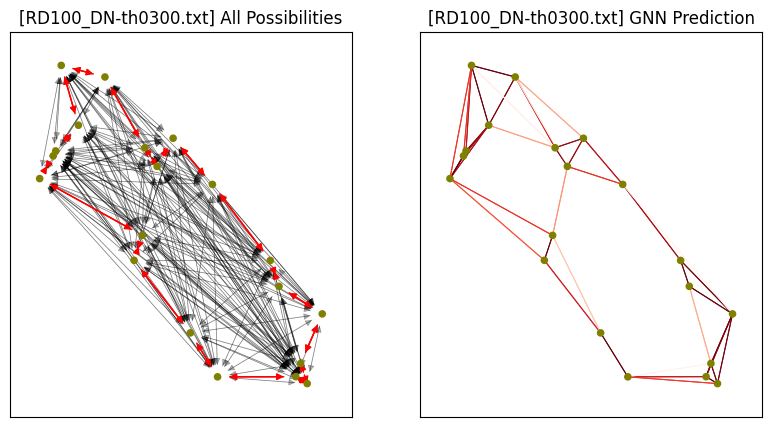

In [ ]:
## Test the model predictions
gcn_model.eval()

test_filepath=f"tsp-data/ortools_{NUM_NODES}_test.txt"
dataset=iter(TSPReader(num_nodes=NUM_NODES, num_neighbors=NUM_NEIGHBORS, batch_size=1, file_path=test_filepath))

x_edges = []
x_edges_values = []
x_nodes_coord = []
y_edges_target = []
y_preds = []

with torch.inference_mode():
    for i in tqdm(range(NUM_NODES)):
        sample=next(dataset)
        x_edges.append(torch.tensor(sample.adj, dtype=torch.int64))
        x_edges_values.append(torch.tensor(sample.dist, dtype=torch.float32))
        x_nodes_coord.append(torch.tensor(sample.coord, dtype=torch.float32))
        y_edges_target.append(torch.tensor(sample.target, dtype=torch.int64))

        # Forward pass
        y_pred=gcn_model(x_edges[-1], x_edges_values[-1], x_nodes_coord[-1])
        y_preds.append(y_pred)

y_preds = torch.squeeze(torch.stack(y_preds))
if num_samples==1:
    y_preds=y_preds.unsqueeze(dim=0)

ml_edge, ml_prob=plot_predictions(x_nodes_coord, x_edges, x_edges_values, y_edges_target, y_preds, num_plots=num_samples, heatmapThreshold=0.3, isShowPath=True, color='r')